## Data Import and Preprocessing

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np

In [3]:
#import data
i8 = pd.read_excel(r"C:\Users\shrut\OneDrive\Desktop\Training\B-Score\i8_cards 2.xlsx")
#i1 = pd.read_excel(r"C:\Users\shrut\OneDrive\Desktop\Training\B-Score\i1_card_transaction 2.xlsx")

In [4]:
data=i8
#data = pd.merge(i8, i1, how='left', on='MASK_CREDITCARD')
data

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,50341.34,0.00,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56926.71,50341.34,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,60332.69,56926.71,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,59646.63,60332.69,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56928.16,59646.63,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142412,2013-03-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,7379.02,1381.36,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,NaN,NaN
142413,2013-04-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,2829.02,7379.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,NaN,NaN
142414,2013-05-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,7819.52,2829.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,NaN,NaN
142415,2013-06-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,10970.93,7819.52,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,NaN,NaN


In [5]:
#data has 142417 rows and 26 columns
data.shape

(142417, 26)

In [6]:
#change datatype of certain columns to desired datatypes
data['NB_DAYS_DELINQ'] = data['NB_DAYS_DELINQ'].astype(str)
data['REGIONS'] = data['REGIONS'].astype(str)
data['NATIONALITY'] = data['NATIONALITY'].astype(str)
data.dtypes

PERIOD                  datetime64[ns]
MASKED_CUSTOMER_ID              object
MASK_CREDITCARD                 object
a_issue_date2           datetime64[ns]
A_card_expiry_date      datetime64[ns]
Customer_Join_Date      datetime64[ns]
CARD_LIMIT                       int64
CASH_LIMIT                       int64
OS_BALANCE                     float64
OPENING_BALANCE                float64
CLOSING_BALANCE                float64
CLOSING_BALANCE_CASH           float64
CLOSING_BALANCE_FEES           float64
NB_DAYS_DELINQ                  object
Customer_Occupation             object
REGIONS                         object
A_Gender                        object
NATIONALITY                     object
A_Marital_Status                object
A_Industry                      object
A_Emp_Sts                       object
A_DOB                   datetime64[ns]
A_Emp_Start             datetime64[ns]
A_No_Depend                    float64
A_salary                       float64
A_Sector                 

In [7]:
#examine data
data.head()

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,50341.34,0.00,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56926.71,50341.34,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,60332.69,56926.71,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,59646.63,60332.69,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56928.16,59646.63,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,NaN,Government


In [8]:
#sort data using MASK_CREDITCARD. Within each MASK_CREDITCARD further dort using PERIOD 
data=data.sort_values(['MASK_CREDITCARD','PERIOD'])

### Continuous Reporting

Check whether the reporting dates for all accounts are continuous.

In [9]:
#create a list for missing reportings. 
#check which accounts have missing reportings by compariing expected dates and actual dates
#remove accounts having discontinuous reporting

missing_reporting=[]
for account, group in data.groupby('MASK_CREDITCARD'):
    actual_months = group['PERIOD'].dt.to_period('M').unique()
    expected_months = pd.period_range(start=group['PERIOD'].min(), end=group['PERIOD'].max(), freq='M')
    missing_months = np.setdiff1d(expected_months, actual_months)
    if missing_months.size > 0:
        missing_reporting.extend([(account, month) for month in missing_months])
        #print(missing_reporting)
        #print(f"Missing reporting months for Credit Card ID {account} are : {missing_months}")

for account, month in missing_reporting:
    data = data[~(data['MASK_CREDITCARD'] == account)]
print(f"No of unique credit cards : {len(data['MASK_CREDITCARD'].unique())}")
print(f"No of credit cards with missing reporting : {len(missing_reporting)}")
print(f"Credit cards with missing reportings : ")
missing_reporting_df = pd.DataFrame(missing_reporting, columns=['MASK_CREDITCARD', 'MISSING_MONTHS'])
missing_reporting_df

No of unique credit cards : 6234
No of credit cards with missing reporting : 9
Credit cards with missing reportings : 


,MASK_CREDITCARD,MISSING_MONTHS
0,FTKUGFNNCFNGGSKT,2013-01
1,FTKUGFNNCFNKTWKP,2010-10
2,FTKUGFNNNKKFTTPP,2012-02
3,FTKUGFNNNNGTTUTW,2010-07
4,FTKUGFNNSGPGNFSW,2011-09
5,FTKUGFNNUCWKGPFC,2011-06
6,FTKUGFNNWNCWFPKU,2013-01
7,FTKUGGNNGTWUKPUS,2011-02
8,FTKUGGNNNNSPFNPC,2010-12


In [10]:
data.shape #examine shape of new dataset

(142080, 26)

### Missing Data Imputation

In [11]:
data.isnull().sum() #check the no of missing values in each column

PERIOD                      0
MASKED_CUSTOMER_ID          0
MASK_CREDITCARD             0
a_issue_date2            1103
A_card_expiry_date          0
Customer_Join_Date      25518
CARD_LIMIT                  0
CASH_LIMIT                  0
OS_BALANCE               3127
OPENING_BALANCE          3127
CLOSING_BALANCE          3127
CLOSING_BALANCE_CASH     3127
CLOSING_BALANCE_FEES     3127
NB_DAYS_DELINQ              0
Customer_Occupation     57455
REGIONS                     0
A_Gender                30926
NATIONALITY                 0
A_Marital_Status        39171
A_Industry              31977
A_Emp_Sts               45143
A_DOB                   25858
A_Emp_Start             83391
A_No_Depend             89764
A_salary                78509
A_Sector                76225
dtype: int64

In [12]:
#impute missing values in numerical variables with 0 
#impute missing values in categorical variables with 'MISSING'
#check if any more missing values are being identified

numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print(numeric_cols)
print(categorical_cols)
data[numeric_cols] = data[numeric_cols].fillna(0)
data[categorical_cols] = data[categorical_cols].fillna('MISSING')
data.isnull().sum()

Index(['CARD_LIMIT', 'CASH_LIMIT', 'OS_BALANCE', 'OPENING_BALANCE',
       'CLOSING_BALANCE', 'CLOSING_BALANCE_CASH', 'CLOSING_BALANCE_FEES',
       'A_No_Depend', 'A_salary'],
      dtype='object')
Index(['MASKED_CUSTOMER_ID', 'MASK_CREDITCARD', 'NB_DAYS_DELINQ',
       'Customer_Occupation', 'REGIONS', 'A_Gender', 'NATIONALITY',
       'A_Marital_Status', 'A_Industry', 'A_Emp_Sts', 'A_Sector'],
      dtype='object')


PERIOD                      0
MASKED_CUSTOMER_ID          0
MASK_CREDITCARD             0
a_issue_date2            1103
A_card_expiry_date          0
Customer_Join_Date      25518
CARD_LIMIT                  0
CASH_LIMIT                  0
OS_BALANCE                  0
OPENING_BALANCE             0
CLOSING_BALANCE             0
CLOSING_BALANCE_CASH        0
CLOSING_BALANCE_FEES        0
NB_DAYS_DELINQ              0
Customer_Occupation         0
REGIONS                     0
A_Gender                    0
NATIONALITY                 0
A_Marital_Status            0
A_Industry                  0
A_Emp_Sts                   0
A_DOB                   25858
A_Emp_Start             83391
A_No_Depend                 0
A_salary                    0
A_Sector                    0
dtype: int64

### Duplicates

In [13]:
#check if there are any duplicates in the data
duplicates = data[data.duplicated()==True]
print(duplicates)

           PERIOD MASKED_CUSTOMER_ID   MASK_CREDITCARD a_issue_date2  \
192    2012-11-30            PPGRTSS  CUKTNSPPNCNCNNNS    2012-11-03   
194    2012-12-31            PPGRTSS  CUKTNSPPNCNCNNNS    2012-11-03   
196    2013-01-31            PPGRTSS  CUKTNSPPNCNCNNNS    2012-11-03   
198    2013-02-28            PPGRTSS  CUKTNSPPNCNCNNNS    2012-11-03   
200    2013-03-31            PPGRTSS  CUKTNSPPNCNCNNNS    2012-11-03   
...           ...                ...               ...           ...   
142021 2013-05-31            GEQEEFG  FTKUGGWPWNTKNNNU    2011-10-06   
142023 2013-06-30            GEQEEFG  FTKUGGWPWNTKNNNU    2011-10-06   
142025 2013-07-31            GEQEEFG  FTKUGGWPWNTKNNNU    2011-10-06   
142375 2012-07-31            PSSEPRR  FTKUGGWWSPCWNNNN    2012-07-19   
142377 2012-08-31            PSSEPRR  FTKUGGWWSPCWNNNN    2012-07-19   

       A_card_expiry_date Customer_Join_Date  CARD_LIMIT  CASH_LIMIT  \
192            2013-07-31         2011-01-15       70000       

In [14]:
#drop duplicated rows from data
data = data.drop_duplicates()
data

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,50341.34,0.00,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56926.71,50341.34,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,60332.69,56926.71,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,59646.63,60332.69,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-07,2013-07-31,2012-02-28,60000,36000,56928.16,59646.63,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142412,2013-03-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,7379.02,1381.36,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142413,2013-04-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,2829.02,7379.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142414,2013-05-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,7819.52,2829.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142415,2013-06-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-21,2013-07-31,2012-01-08,12500,7500,10970.93,7819.52,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING


### Impute Date Columns

In [15]:
#in some cases, reporting date and other dates are in middle of the month. substitute them with dates at end of same month
date_columns = ['PERIOD','a_issue_date2','Customer_Join_Date']
for col in date_columns:
    data[col] = data[col] + pd.offsets.MonthEnd(0)
data

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,50341.34,0.00,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56926.71,50341.34,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,60332.69,56926.71,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,59646.63,60332.69,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56928.16,59646.63,...,MALE,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142412,2013-03-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7379.02,1381.36,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142413,2013-04-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,2829.02,7379.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142414,2013-05-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7819.52,2829.02,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING
142415,2013-06-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,10970.93,7819.52,...,FEMALE,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING


### Same DPD for same PERIOD and MASK_CREDITCARD 

In [16]:
#check if there are any rows with same MASK_CREDITCARD and same PERIOD which have different DPD Days.
#in that case, impute them with max DPD and check once again.

duplicate_groups = data.groupby(['PERIOD', 'MASK_CREDITCARD']).filter(lambda x: len(x) > 1)

print("Rows with the same PERIOD and MASK_CREDITCARD before transformation:")
print(duplicate_groups['NB_DAYS_DELINQ'])

Rows with the same PERIOD and MASK_CREDITCARD before transformation:
101838    1.0
101839    0.0
Name: NB_DAYS_DELINQ, dtype: object


In [17]:
data['NB_DAYS_DELINQ'] = data.groupby(['PERIOD', 'MASK_CREDITCARD'])['NB_DAYS_DELINQ'].transform('max')

In [18]:
duplicate_groups = data.groupby(['PERIOD', 'MASK_CREDITCARD']).filter(lambda x: len(x) > 1)

print("Rows with the same PERIOD and MASK_CREDITCARD after transformation:")
duplicate_groups['NB_DAYS_DELINQ']

Rows with the same PERIOD and MASK_CREDITCARD after transformation:


101838    1.0
101839    1.0
Name: NB_DAYS_DELINQ, dtype: object

### Replace values in NB_DAYS_DELINQ that are greater than 4 with '5+'

In [19]:
data['NB_DAYS_DELINQ'] = data['NB_DAYS_DELINQ'].replace('nan', '0.0').apply(lambda x: '5.0' if (pd.notna(x) and float(x) > 4) else x)
data['NB_DAYS_DELINQ'].unique()

array(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], dtype=object)

In [20]:
data['NB_DAYS_DELINQ'].value_counts()

NB_DAYS_DELINQ
0.0    94801
1.0    19917
5.0    17192
2.0     4296
3.0     1616
4.0      997
Name: count, dtype: int64

In [21]:
data1 = data

## Roll Rate

In [22]:
#find credit card accounts having atleast 18 months of reporting data. drop accounts which have less than 18  months of data

data1['entry_count'] = data1.groupby('MASK_CREDITCARD')['MASK_CREDITCARD'].transform('size')
data1 = data1[data1['entry_count'] >= 18].drop(['entry_count'],axis=1)
len(data1['MASK_CREDITCARD'].unique())

2987

In [23]:
data1

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
6056,2011-09-30,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,33513.00,0.00,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6057,2011-10-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,39713.55,33513.00,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6058,2011-11-30,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,40754.38,39713.55,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6059,2011-12-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,39827.63,40754.38,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6060,2012-01-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,40625.53,39827.63,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142395,2013-03-31,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4297.47,4373.88,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142396,2013-04-30,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4676.22,4297.47,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142397,2013-05-31,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4615.31,4676.22,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142398,2013-06-30,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4207.44,4615.31,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government


In [24]:
#sort this new data by MASK_CREDITCARD and then further by PERIOD. 
# divide the data into data from first 9 months and data from 9 to 18 months

data1 = data1.sort_values(['MASK_CREDITCARD','PERIOD'])
first_9_months = data1.groupby('MASK_CREDITCARD').head(9)
next_9_months = data1.groupby('MASK_CREDITCARD').apply(lambda x: x.iloc[9:18]).reset_index(drop=True)

#len(next_9_months['MASK_CREDITCARD'].unique())
first_9_months

C:\Users\shrut\AppData\Local\Temp\ipykernel_17996\1317658611.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  next_9_months = data1.groupby('MASK_CREDITCARD').apply(lambda x: x.iloc[9:18]).reset_index(drop=True)


,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Gender,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector
6056,2011-09-30,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,33513.00,0.00,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6057,2011-10-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,39713.55,33513.00,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6058,2011-11-30,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,40754.38,39713.55,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6059,2011-12-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,39827.63,40754.38,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
6060,2012-01-31,FTTGSTT,FCPFSTNTFNUSNNNG,2011-09-30,2013-07-31,2011-09-30,40000,24000,40625.53,39827.63,...,FEMALE,784,MARRIED,PERSONAL,EMPLOYED,1978-07-17,2010-06-06,0.0,0.0,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142382,2012-02-29,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,127.64,173.73,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142383,2012-03-31,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4952.75,127.64,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142384,2012-04-30,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,5064.29,4952.75,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government
142385,2012-05-31,FQFFFGQ,FTKUGGWWUFFSNNNW,NaT,2013-07-31,2009-03-31,5000,3000,4870.00,5064.29,...,FEMALE,784,DIVORCED,PERSONAL,EMPLOYED,1969-11-21,1997-01-01,0.0,24157.5,Government


In [25]:
#create a transition matrix representing the no of accounts that show change in DPD Bucket

transition_matrix = pd.crosstab(
    first_9_months.groupby('MASK_CREDITCARD')['NB_DAYS_DELINQ'].max(),
    next_9_months.groupby('MASK_CREDITCARD')['NB_DAYS_DELINQ'].max(),
    rownames=['First 9 months'],
    colnames=['Next 9 months']
)
transition_matrix

Next 9 months,0.0,1.0,2.0,3.0,4.0,5.0
First 9 months,,,,,,
0.0,916,228,13,5,0,36
1.0,247,574,121,22,10,16
2.0,40,126,83,38,10,28
3.0,3,26,29,18,12,24
4.0,1,3,5,9,1,29
5.0,4,7,4,7,3,289


In [26]:
#calculate rolling forward rate and rolling backward rate

buckets = ['0.0','1.0','2.0','3.0','4.0','5.0']
roll_forward_rates = []
for bucket in buckets:
    total = transition_matrix.loc[bucket].sum()
    forward = transition_matrix.loc[bucket, buckets[buckets.index(bucket)+1:]].sum()
    roll_forward_rates.append((forward / total) * 100)
print(roll_forward_rates)

buckets = ['0.0','1.0','2.0','3.0','4.0','5.0']
roll_backward_rates = []
for bucket in buckets:
    total = transition_matrix.loc[bucket].sum()
    backward = transition_matrix.loc[bucket,buckets[:buckets.index(bucket)]].sum()
    roll_backward_rates.append((backward/ total) * 100)
print(roll_backward_rates)

[np.float64(23.53923205342237), np.float64(17.07070707070707), np.float64(23.384615384615383), np.float64(32.142857142857146), np.float64(60.416666666666664), np.float64(0.0)]
[np.float64(0.0), np.float64(24.949494949494948), np.float64(51.07692307692307), np.float64(51.78571428571429), np.float64(37.5), np.float64(7.961783439490445)]


In [27]:
#create a dataframe for roll rate.

roll_rate = pd.DataFrame({'buckets' : buckets, 'roll_forward_rates' : roll_forward_rates, 'roll_backward_rates' : roll_backward_rates})
roll_rate

,buckets,roll_forward_rates,roll_backward_rates
0,0.0,23.539232,0.000000
1,1.0,17.070707,24.949495
2,2.0,23.384615,51.076923
3,3.0,32.142857,51.785714
4,4.0,60.416667,37.500000
5,5.0,0.000000,7.961783


## Vintage Analysis

In [28]:
data2 = data
data2

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,NATIONALITY,A_Marital_Status,A_Industry,A_Emp_Sts,A_DOB,A_Emp_Start,A_No_Depend,A_salary,A_Sector,entry_count
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,50341.34,0.00,...,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government,9
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56926.71,50341.34,...,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government,9
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,60332.69,56926.71,...,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government,9
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,59646.63,60332.69,...,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government,9
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56928.16,59646.63,...,784,MARRIED,PERSONAL,EMPLOYED,1962-03-25,2003-09-01,2.0,0.0,Government,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142412,2013-03-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7379.02,1381.36,...,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING,17
142413,2013-04-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,2829.02,7379.02,...,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING,17
142414,2013-05-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7819.52,2829.02,...,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING,17
142415,2013-06-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,10970.93,7819.52,...,124,MARRIED,PERSONAL,EMPLOYED,1959-01-14,2004-02-09,2.0,0.0,MISSING,17


In [29]:
data2['First_Reporting'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform('min')
data2['Default'] = data2['NB_DAYS_DELINQ'].astype(float) >= 4
data2['First_Default_Date'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform(lambda x: x[data2['Default']].min())
data2['Is_First_Default'] = data2['PERIOD'] == data2['First_Default_Date']
data2['Months_to_Default'] = np.where(
    data2['Is_First_Default'],
    (data2['PERIOD'] - data2['First_Reporting']).dt.days // 30,
    np.nan
)
data2['First_Reporting'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform('min').dt.year
data2

,PERIOD,MASKED_CUSTOMER_ID,MASK_CREDITCARD,a_issue_date2,A_card_expiry_date,Customer_Join_Date,CARD_LIMIT,CASH_LIMIT,OS_BALANCE,OPENING_BALANCE,...,A_Emp_Start,A_No_Depend,A_salary,A_Sector,entry_count,First_Reporting,Default,First_Default_Date,Is_First_Default,Months_to_Default
0,2012-11-30,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,50341.34,0.00,...,2003-09-01,2.0,0.0,Government,9,2012,False,NaT,False,NaN
1,2012-12-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56926.71,50341.34,...,2003-09-01,2.0,0.0,Government,9,2012,False,NaT,False,NaN
2,2013-01-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,60332.69,56926.71,...,2003-09-01,2.0,0.0,Government,9,2012,False,NaT,False,NaN
3,2013-02-28,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,59646.63,60332.69,...,2003-09-01,2.0,0.0,Government,9,2012,False,NaT,False,NaN
4,2013-03-31,DHSSDDG,CUKTNSPPNCCCNNNC,2012-11-30,2013-07-31,2012-02-29,60000,36000,56928.16,59646.63,...,2003-09-01,2.0,0.0,Government,9,2012,False,NaT,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142412,2013-03-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7379.02,1381.36,...,2004-02-09,2.0,0.0,MISSING,17,2012,False,NaT,False,NaN
142413,2013-04-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,2829.02,7379.02,...,2004-02-09,2.0,0.0,MISSING,17,2012,False,NaT,False,NaN
142414,2013-05-31,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,7819.52,2829.02,...,2004-02-09,2.0,0.0,MISSING,17,2012,False,NaT,False,NaN
142415,2013-06-30,SRDFPFR,FTKUGGWWUNGPNNNT,2012-03-31,2013-07-31,2012-01-31,12500,7500,10970.93,7819.52,...,2004-02-09,2.0,0.0,MISSING,17,2012,False,NaT,False,NaN


In [30]:
pivot_table = pd.pivot_table(
    data2.dropna(subset=['Months_to_Default']),
    values='MASK_CREDITCARD', 
    index='Months_to_Default',
    columns='First_Reporting',
    aggfunc='nunique',  
    fill_value=0      
)
pivot_table

First_Reporting,2008,2009,2010,2011,2012,2013
Months_to_Default,,,,,,
0.0,0,0,5,0,4,0
2.0,0,0,1,0,1,0
3.0,0,0,0,0,1,1
4.0,0,170,7,3,22,2
5.0,0,69,1,1,8,1
6.0,0,65,4,0,12,1
7.0,27,12,1,5,5,0
8.0,50,16,5,4,7,0
9.0,31,4,1,3,5,0


In [33]:
data2['First_Reporting'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform('min')
data2['Default'] = data2['NB_DAYS_DELINQ'].astype(float) >= 4
data2['First_Default_Date'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform(lambda x: x[data2['Default']].min())
data2['Is_First_Default'] = data2['PERIOD'] == data2['First_Default_Date']
data2['Months_to_Default'] = np.where(
    data2['Is_First_Default'],
    (data2['PERIOD'] - data2['First_Reporting']).dt.days // 30,
    np.nan
)
data2['First_Reporting'] = data2.groupby('MASK_CREDITCARD')['PERIOD'].transform('min').dt.year

# Group by Months_to_Default and First_Reporting and count unique MASK_CREDITCARD
grouped = data2.dropna(subset=['Months_to_Default']).groupby(['Months_to_Default', 'First_Reporting'])['MASK_CREDITCARD'].nunique().unstack(fill_value=0)

total_accounts_per_year = data2.groupby('First_Reporting')['MASK_CREDITCARD'].nunique()
normalized_grouped = grouped.divide(total_accounts_per_year, axis=1)

cumulative_normalized_grouped = normalized_grouped.cumsum()


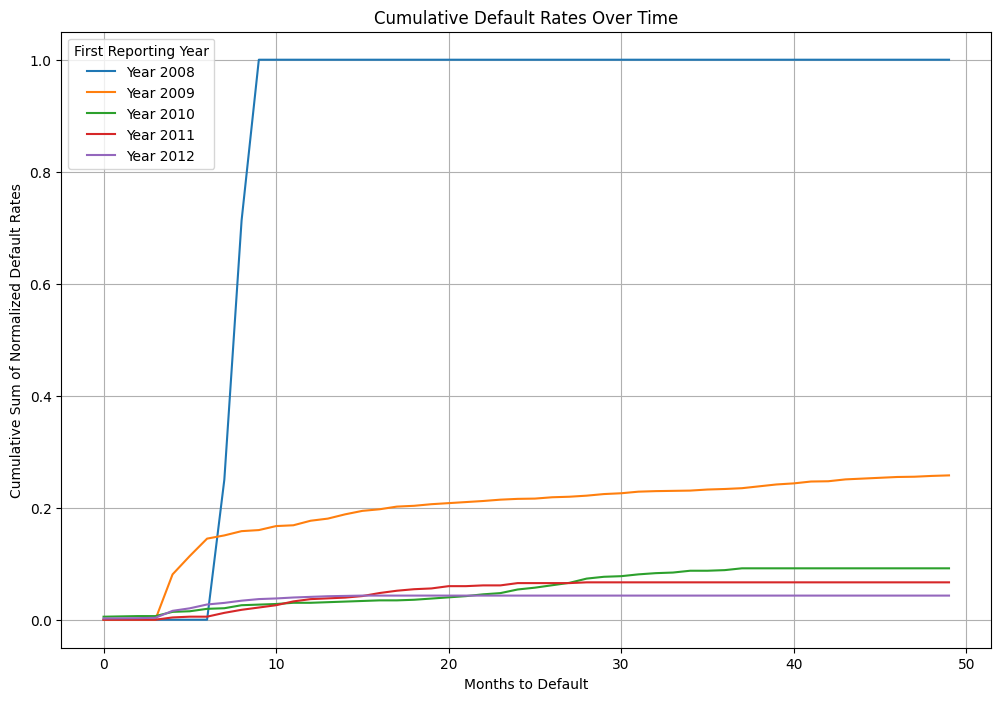

In [34]:
import matplotlib.pyplot as plt

# Plotting the cumulative sum for each year
plt.figure(figsize=(12, 8))

for year in cumulative_normalized_grouped.columns[:-1]:  # Exclude the 'Total' column
    plt.plot(
        cumulative_normalized_grouped.index,  # Months on x-axis
        cumulative_normalized_grouped[year],  # Cumulative sum on y-axis
        label=f'Year {year}'  # Label for each year
    )

# Adding titles and labels
plt.title('Cumulative Default Rates Over Time')
plt.xlabel('Months to Default')
plt.ylabel('Cumulative Sum of Normalized Default Rates')

# Adding a legend
plt.legend(title='First Reporting Year')

# Display the plot
plt.grid(True)
plt.show()